# <center> Characterizing Machine Learning I/O Workloads on Leadership Scale HPC Systems 
## <center> [MASCOTS 2021]

In [2]:
import os
import pandas as pd
from datetime import datetime, timedelta
import glob
import numpy as np
import uuid # to generate a long key


In [2]:
%reload_ext dotenv
%dotenv

In [3]:
DARSHAN_PARENT_DIR = os.getenv("DARSHAN_PARENT_DIR")
JOB_DATA_DIR = os.getenv("JOB_DATA_DIR")

In [4]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 150)

# List of ML keywords

In [16]:
kwrd_df = pd.read_csv(f'../mlKeywords.txt')
kwrd_df

,Keyword,flag
0,keras,sure
1,training,sure
2,solr_keras,sure
3,candle_keras,sure
4,tensorflow,sure
5,interpolate,sure
6,DeepBench,sure
7,MonteCarlo_MachineLearning,sure
8,sklearn,sure
9,horovod,sure


# Find jobs having ML keywords

### Before moving further :

- If you haven't executed the following codes, run the code "../code/darshan_ml_jobs.py"
   - use slurm script in "../slurm_dir/darshan_ml_jobs.slurm" to run darshan_ml_jobs.py

In [6]:
#anomalous job days when there are unexpectedly large number of jobs were recorded which did not run
anomolous_days = ['2020-07-08','2020-07-09','2020-07-10','2020-07-12','2020-07-13','2020-07-14',
                  '2020-07-15','2020-07-16','2020-07-17','2020-07-18','2020-07-19','2020-07-22',
                  '2020-07-23','2020-07-24','2020-07-25','2020-07-26','2020-07-27','2020-07-29',
                  '2020-07-30','2020-07-31','2020-08-03','2020-08-04','2020-08-06','2020-08-07',
                  '2020-08-10','2020-08-11','2020-08-12']

In [ ]:
months=['Jan2020','Feb2020','Mar2020','Apr2020','May2020','Jun2020','Jul2020','Aug2020','Sep2020','Oct2020','Nov2020','Dec2020']
#months=[1,2,3,4,5,6,7,8,9,10,11,12]
days_lst=[31,29,31,30,31,30,31,31,30,31,30,31]
ml_keyword_jobs = pd.DataFrame()
break_flag=False
for mnth_cntr, month in enumerate(months):
    for day in range(1,days_lst[mnth_cntr]+1):
        #print(day,month,end='~')
        day_patrn = f'2020-{str(mnth_cntr+1).zfill(2)}-{str(day).zfill(2)}'
        ini_file = f'{DARSHAN_PARENT_DIR}/{month}/{day}/darshan_ml_keywords_jobs.csv'
        try:
            loop_df = pd.read_csv(ini_file)
        except Exception as ex:
            message = f'An exception of type {type(ex).__name__} occurerd. Arguments: {ex.args} for {day},{month}'
            #print('\n','\n',message)
            continue
        if day_patrn in anomolous_days:
            #print("anomaly 1", day_patrn, month, day,loop_df.shape)
            anomolous_uid = [14250,12756,13150,4069,15557,15883,13438,8445]
            #Darshan_Total.csv is a file generated by darshan-util --total for all darshan trace in a day.  
            darshan_file = f'{DARSHAN_PARENT_DIR}/{month}/{day}/Darshan_Total.csv' 
            darshan_df_jobs = pd.read_csv(darshan_file)
            darshan_df_jobs = darshan_df_jobs[darshan_df_jobs['uid'].isin(anomolous_uid)]
            anomalous_jobs_list = darshan_df_jobs['jobid'].values
            loop_df = loop_df[~loop_df['job_id'].isin(anomalous_jobs_list)]
        ml_keyword_jobs = pd.concat([ml_keyword_jobs,loop_df],axis=0)

ml_keyword_jobs['year_month'] = ml_keyword_jobs['job_date'].str[0:7]

In [22]:
#save ml_keyword_jobs object
#ml_keyword_jobs.to_csv('../ml_keywords_jobs.csv')

In [8]:
ml_keyword_jobs = pd.read_csv(f'../ml_keywords_jobs.csv',index_col=0)
date_list = [temp_dt.strftime('%Y-%m-%d') for temp_dt in pd.date_range(start='2020-01-01',end='2020-12-31')]

## Classify ML jobs into Burst Buffer and PFS jobs
- Filesytems:
  - Burst Buffer (BB) - XFS
  - Parallel Filesystem - GPFS (Exclusively Non-XFS)  
  
We go through all the detailed darshan traces of all the ML jobs and based on the filesystem of all files in a job we group the jobs into two categories.
If the job has no file on XFS, then we group them as GPFS jobs and if it has files on both GPFS and XFS then we call them as BB jobs

In [ ]:
xfs_jobs = []
xfs_jobs_date = []
non_xfs_jobs = []
non_xfs_jobs_date = []
for job_date in date_list:
    print(job_date, end "~")
    month_str = datetime.strftime(datetime.strptime(job_date,'%Y-%m-%d'),'%Y-%b-%d')[5:8]
    year_str = datetime.strftime(datetime.strptime(job_date,'%Y-%m-%d'),'%Y-%b-%d')[0:4]
    year_month_str = f'{month_str}{year_str}'
    day_str = str(int(datetime.strftime(datetime.strptime(job_date,'%Y-%m-%d'),'%Y-%b-%d')[9:]))
    data_path = f'{DARSHAN_PARENT_DIR}/{year_month_str}/{day_str}/jobwise_darshan_restructure/'

    day_ml_jobs = ml_keyword_jobs[ml_keyword_jobs['job_date']==job_date]
    day_jobs_list = day_ml_jobs['job_id'].values
    for job_ins in day_jobs_list:
        #print(f'{data_path}{job_ins}.csv')
        fstype_darshan_df = pd.read_csv(f'{data_path}{job_ins}.csv',usecols=['fstype'])
        fstype_darshan_df = (fstype_darshan_df[(fstype_darshan_df['fstype'] == 'gpfs') |
                                               (fstype_darshan_df['fstype'] == 'xfs')])
        if fstype_darshan_df.empty:
            continue
        if 'xfs' in fstype_darshan_df.fstype.values:
            xfs_jobs.append(job_ins)
            xfs_jobs_date.append(job_date)
        else:
            non_xfs_jobs.append(job_ins)
            non_xfs_jobs_date.append(job_date)            
            
        

### We save the results in a two seperate csv files one each for BB jobs and GPFS jobs.

In [9]:
#If running for the first time uncomment following lines to save the result and then comment it back so you do not overwrite them later.

# xfs_jobs_df  = pd.DataFrame({'jobid':xfs_jobs, 'job_date':xfs_jobs_date})
# non_xfs_jobs_df  = pd.DataFrame({'jobid':non_xfs_jobs, 'job_date':non_xfs_jobs_date})

# xfs_jobs_df.to_csv('../processed_data/xfs_jobs.csv')
# non_xfs_jobs_df.to_csv('../processed_data/non_xfs_jobs.csv')

xfs_jobs_df = pd.read_csv('../processed_data/xfs_jobs.csv', index_col=0)
non_xfs_jobs_df = pd.read_csv('../processed_data/non_xfs_jobs.csv', index_col=0)


## Job Scheduler Data
- We need job scheduler dataset to map Darshan job ids with domain science

In [10]:
job_schd_df = pd.read_csv(f'{JOB_DATA_DIR}/jobwise_combine.csv')

In [11]:
job_schd_df1 = job_schd_df[['primary_job_id','job_domain','begin_time','job_time','num_nodes']]
job_schd_df1['begin_time'] = job_schd_df1['begin_time'].str[0:10]


/tmp/ipykernel_161/1793335630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  job_schd_df1['begin_time'] = job_schd_df1['begin_time'].str[0:10]


In [12]:
job_schd_df1 = job_schd_df1.rename(columns={'primary_job_id':'jobid','begin_time':'job_date'})
job_schd_df1 = (job_schd_df1.groupby(['jobid','job_date',]).
                agg(job_domain=('job_domain','first'),job_time=('job_time','max'),
                    num_nodes=('num_nodes',max)).reset_index())


In [13]:
#Subtracting one day (5hrs) because of UTC and Local Timezone difference before merging with darshan data
job_schd_df2 = job_schd_df1.copy()
job_schd_df2['job_date'] = (pd.to_datetime(job_schd_df2['job_date'])+timedelta(-1)).dt.strftime('%Y-%m-%d')

## Burst buffer jobs domain

In [14]:
#same day for UTC and Local Timezone
xfs_domain = xfs_jobs_df.merge(job_schd_df1,how='inner')#


In [15]:
##UTC day ahead of local Timezone
xfs_domain_2 = job_schd_df2.merge(xfs_jobs_df,how='inner')
xfs_jobs_domainwise = pd.concat([xfs_domain, xfs_domain_2],axis=0)


In [16]:
xfs_jobs_domainwise = xfs_jobs_domainwise.groupby(['jobid','job_date']).agg(job_domain=('job_domain','first'),
                                                         job_time=('job_time','max'),
                                                         num_nodes=('num_nodes','max')).reset_index()

In [17]:
xfs_jobs_domainwise

,jobid,job_date,job_domain,job_time,num_nodes
0,4579.0,2020-03-30,BIF,4594.0,32.0
1,4638.0,2020-03-30,VEN,1533.0,2.0
2,4723.0,2020-03-30,VEN,4901.0,8.0
3,5101.0,2020-03-30,VEN,1431.0,8.0
4,5168.0,2020-03-30,VEN,2080.0,8.0
...,...,...,...,...,...
1037,998766.0,2020-03-27,BIF,1884.0,16.0
1038,998767.0,2020-03-27,BIF,1860.0,16.0
1039,998768.0,2020-03-27,BIF,3624.0,16.0
1040,998820.0,2020-03-27,BIF,3619.0,32.0


## GPFS (non-XFS) jobs domain

In [18]:
non_xfs_domain = non_xfs_jobs_df.merge(job_schd_df1,how='inner')#
non_xfs_domain_2 = non_xfs_jobs_df.merge(job_schd_df2,how='inner')#


In [19]:
non_xfs_jobs_domainwise = pd.concat([non_xfs_domain, non_xfs_domain_2],axis=0)

In [20]:
non_xfs_jobs_domainwise = non_xfs_jobs_domainwise.groupby(['jobid','job_date']).agg(job_domain=('job_domain','first'),
                                                         job_time=('job_time','max'),
                                                         num_nodes=('num_nodes','max')).reset_index()



## Few jobs domain were nor defined in Job Scheduler logs. So get them from the path.
- This is very specific to our work, no need to run if all job domains were found from Scheduler log

### 1. BB/XFS Jobs

In [21]:
msng_xfs_job = xfs_jobs_df.merge(xfs_jobs_domainwise,how='left')
msng_xfs_job = msng_xfs_job[msng_xfs_job.isna().any(axis=1)]


### 2. GPFS/ non-XFS Jobs

In [22]:
msng_non_xfs_job = non_xfs_jobs_df.merge(non_xfs_jobs_domainwise,how='left')#.isna()#['job']
msng_non_xfs_job = msng_non_xfs_job[msng_non_xfs_job.isna().any(axis=1)]


In [23]:
#combine missing jobs
missing_jobs_in_schd_logs = pd.concat([msng_non_xfs_job,msng_xfs_job],axis=0)
missing_jobs_in_schd_logs.to_csv('../processed_data/missing_jobs_in_schd_log.csv',index=False)

In [24]:
missing_jobs_in_schd_logs

,jobid,job_date,job_domain,job_time,num_nodes
38,22140,2020-01-08,NaN,NaN,NaN
48,68977,2020-01-09,NaN,NaN,NaN
49,70769,2020-01-09,NaN,NaN,NaN
72,29612,2020-01-10,NaN,NaN,NaN
73,59132,2020-01-10,NaN,NaN,NaN
...,...,...,...,...,...
22095,613377,2020-12-28,NaN,NaN,NaN
562,274427,2020-08-11,NaN,NaN,NaN
565,274430,2020-08-11,NaN,NaN,NaN
654,292167,2020-08-20,NaN,NaN,NaN


### To get the domain from the paths, run slurm job of missing_jobs_domain.py using missing_jobs_domain.slurm

In [26]:
msng_domain_jobs = pd.read_csv('../processed_data/missing_jobs_in_schd_log_domain_path.csv')
msng_domain_jobs = msng_domain_jobs.loc[:,['jobid','job_date','path_1','path_2']]

msng_domain_jobs = msng_domain_jobs.replace('proj-shared',np.nan)
msng_domain_jobs = msng_domain_jobs.replace('scratch',np.nan)
msng_domain_jobs = msng_domain_jobs.replace('world-shared',np.nan)
msng_domain_jobs = msng_domain_jobs.replace('jtschw','lrn007')
msng_domain_jobs = msng_domain_jobs.replace('nvcastet','ven201')

#msng_domain_jobs[(msng_domain_jobs['path_1_len']!=6) |(msng_domain_jobs['path_1_len'].notnull())]
#msng_domain_jobs[(msng_domain_jobs['path_2_len'].notna()) & (msng_domain_jobs['path_2_len']!=6)]
#t1=msng_domain_jobs[(msng_domain_jobs['path_2'].notna())]
msng_domain_jobs['job_domain'] = msng_domain_jobs['path_2']
msng_domain_jobs.loc[msng_domain_jobs['job_domain'].isnull(),'job_domain'] = msng_domain_jobs['path_1']    


In [50]:
msng_xfs_job

,jobid,job_date,job_domain,job_time,num_nodes
562,274427,2020-08-11,NaN,NaN,NaN
565,274430,2020-08-11,NaN,NaN,NaN
654,292167,2020-08-20,NaN,NaN,NaN
929,439227,2020-10-26,NaN,NaN,NaN


In [27]:
msng_domain_jobs
msng_domain_jobs

,jobid,job_date,path_1,path_2,job_domain
0,22140,2020-01-08,NaN,ven201,ven201
1,68977,2020-01-09,NaN,ven201,ven201
2,70769,2020-01-09,NaN,ven201,ven201
3,29612,2020-01-10,NaN,ven201,ven201
4,59132,2020-01-10,NaN,ven201,ven201
...,...,...,...,...,...
7538,613377,2020-12-28,syb105,NaN,syb105
7539,274427,2020-08-11,mat110,NaN,mat110
7540,274430,2020-08-11,mat110,NaN,mat110
7541,292167,2020-08-20,mat110,NaN,mat110


In [28]:
xfs_jobs_domainwise = pd.concat([xfs_jobs_domainwise, msng_xfs_job.loc[:,['jobid','job_date']].merge(msng_domain_jobs.loc[:,['jobid','job_date','job_domain']],how='left')],axis=0).reset_index(drop=True)
non_xfs_jobs_domainwise = pd.concat([non_xfs_jobs_domainwise, msng_non_xfs_job.loc[:,['jobid','job_date']].merge(msng_domain_jobs.loc[:,['jobid','job_date','job_domain']],how='left')],axis=0).reset_index(drop=True)


### Label jobs and combine dataframes

In [35]:
xfs_jobs_domainwise['file_system']= 'Burst Buffer'
non_xfs_jobs_domainwise['file_system'] = 'GPFS'

jobs_domainwise_df = pd.concat([xfs_jobs_domainwise,non_xfs_jobs_domainwise],axis=0)

### Convert project codes to genereic names

In [37]:
map_domain_science = pd.read_csv("../ornlProjects.csv")
replace_dict = {idx:map_domain_science['Science'][c] for (c,idx) in enumerate(map_domain_science['ID'].values)}


In [38]:
jobs_domainwise_df['job_domain'] = jobs_domainwise_df['job_domain'].str[0:3].str.upper()
jobs_domainwise_df['job_domain'] = jobs_domainwise_df['job_domain'].replace(replace_dict)


### Save jobs data, so as to avoid running above codes

In [ ]:
#jobs_domainwise_df.to_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index=False)

### Data processing is complete!!!

In [42]:
jobs_domainwise_df = pd.read_csv("../processed_data/calculated_jobs_for_domain_fsType.csv",index_col=None)


In [47]:
pd.unique(jobs_domainwise_df['job_domain'])

array(['Biology', 'Comp. Sc.', 'Materials', 'Chemistry', 'Earth Sc.',
       'Physics', 'Mach. Learn.', 'Engineering', 'Fusion'], dtype=object)

In [48]:
jobs_domainwise_df[jobs_domainwise_df['job_domain']=='Materials']

,jobid,job_date,job_domain,job_time,num_nodes,file_system
221,263882.0,2020-08-05,Materials,11458.0,10.0,Burst Buffer
222,264096.0,2020-08-05,Materials,3564.0,3.0,Burst Buffer
233,265526.0,2020-08-06,Materials,7280.0,4.0,Burst Buffer
234,265760.0,2020-08-06,Materials,450.0,4.0,Burst Buffer
236,265981.0,2020-08-06,Materials,3373.0,8.0,Burst Buffer
...,...,...,...,...,...,...
15865,978696.0,2020-03-18,Materials,NaN,NaN,GPFS
15866,979532.0,2020-03-18,Materials,NaN,NaN,GPFS
15867,980753.0,2020-03-19,Materials,NaN,NaN,GPFS
15868,981588.0,2020-03-19,Materials,NaN,NaN,GPFS


## Plots

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

In [44]:

# Initialize style
plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 8.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    """Width driven sizing for seaborn multi-grid layouts
    
    Derive height & aspect kwargs for facetgrid, pairgrid & friends with a target sizing
    in terms of width and height.  Convenient for creating figures that has
    to be fit into a certain width, while maintaining the correct aspect ratios of the fonts.
    Call this function to derive the height & aspect
    
    Currently, ACM & IEEE latex, single column figure defaults to a width of 8inch
    and the double column figure defaults to a width of 8 inch for the correct text scaling
    
    Usage:
    - sns.FacetGrid( ... , **width_height())

    :param width: target width in inches (4 inch for a single column figure is default)
    :param height: target heigth in inches (width * 3/4 - golden ratio is the default)
    :param columns: target # of columns for facetgrid
    :param rows: target # of rows for facetgrid
    """
    if height is None:
        height = width * 3/5
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

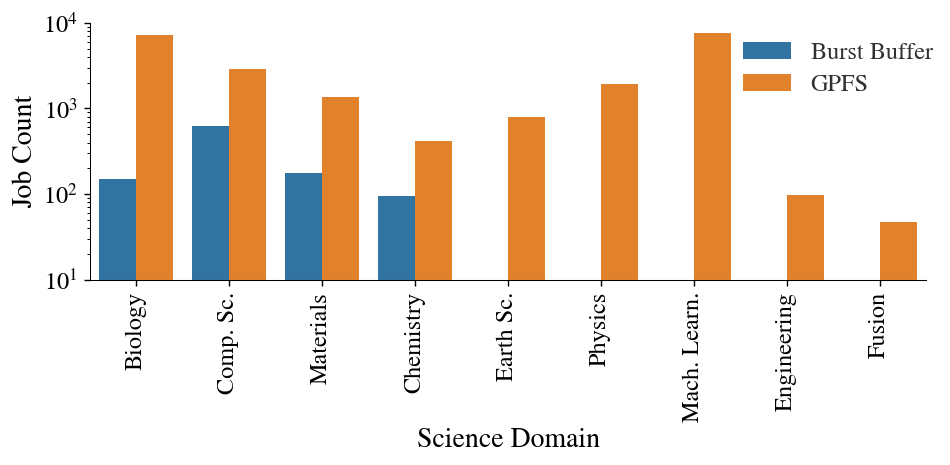

In [45]:
blue, orange = sns.color_palette('deep', n_colors=2)
DOUBLE_COLUMN = DOUBLE_WIDTH = 8.0
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 16, 'font.family': 'STIXGeneral'})


fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*3/6))
sns.countplot(ax=axes,data=jobs_domainwise_df, x="job_domain",hue="file_system")
axes.set_xticklabels(axes.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
axes.set(ylabel="Job Count", xlabel="Science Domain")
axes.set(yscale='log')
#None
    
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

trans = mtrans.Affine2D().translate(10, 0)
for t in axes.get_xticklabels():
    t.set_transform(t.get_transform()+trans)
#plt.legend(loc='upper right')
axes.legend(fontsize=14, frameon=False)
axes.legend_._set_loc(2)
axes.legend_.set_bbox_to_anchor((0.76, 0.99))

fig.tight_layout()
fig.savefig("../plots/xfs_vs_pfs_domainwise.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)



## Assign class based on number of nodes 

In [50]:
def assign_summit_job_class(df_f):
    job_node_class = [(df_f['num_nodes']<=45),
                      (df_f['num_nodes']>45)&(df_f['num_nodes']<=91),
                      (df_f['num_nodes']>91)&(df_f['num_nodes']<=921),
                      (df_f['num_nodes']>921)&(df_f['num_nodes']<=2764),
                      (df_f['num_nodes']>2764)]
    values_cl = [5,4,3,2,1]
    df_f['class'] = np.select(job_node_class,values_cl)
    return df_f 

In [51]:
def assign_summit_group(df_f):
    job_group = [(df_f['class']==5),
                      (df_f['class']==4)|(df_f['class']==3),
                      (df_f['class']==2)|(df_f['class']==1)]
    group = ['small','medium','flagship']
    df_f['group'] = np.select(job_group,group)
    return df_f

In [53]:
job_node_class = [(jobs_domainwise_df['num_nodes']<=45),
                (jobs_domainwise_df['num_nodes']>45)&(jobs_domainwise_df['num_nodes']<=91),
                (jobs_domainwise_df['num_nodes']>91)&(jobs_domainwise_df['num_nodes']<=921),
                (jobs_domainwise_df['num_nodes']>921)&(jobs_domainwise_df['num_nodes']<=2764),
                (jobs_domainwise_df['num_nodes']>2764)]


In [54]:
values_cl = ['5','4','3','2','1']
jobs_domainwise_df['Class'] = np.select(job_node_class,values_cl)


In [55]:
flagship_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='1') | (jobs_domainwise_df['Class']=='2')]
medium_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='3') | (jobs_domainwise_df['Class']=='4')]
small_jobs = jobs_domainwise_df[(jobs_domainwise_df['Class']=='5')]

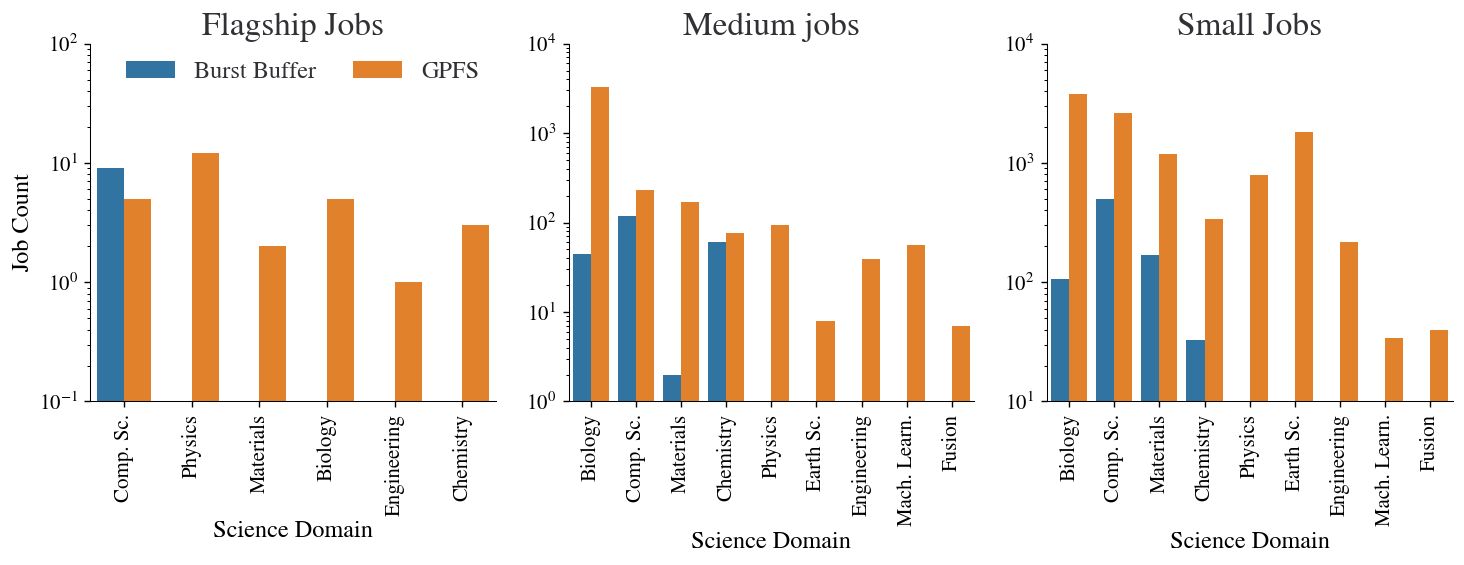

In [59]:
plt.style.use("acm_ieee_latex_pubstyle.txt")

blue, orange = sns.color_palette('deep', n_colors=2)
DOUBLE_COLUMN = DOUBLE_WIDTH = 12.0
sns.set_context(rc = {'patch.linewidth': 0.0, 'axes.labelsize': 14, 'font.family': 'STIXGeneral'})


fig, axes = plt.subplots(nrows=1, ncols=3,
                         figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH*2/5))
p0 = sns.countplot(ax=axes[0],data=flagship_jobs, x="job_domain",hue="file_system")
p0.set_xticklabels(p0.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
p0.set(ylabel="Job Count", xlabel="Science Domain")
p0.set(yscale='log')
#axes[0].set(yscale='log')
#None
p1 = sns.countplot(ax=axes[1],data=medium_jobs, x="job_domain",hue="file_system")
p1.set_xticklabels(p1.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
p1.set(ylabel=None, xlabel="Science Domain")
p1.set(yscale='log')

p2 = sns.countplot(ax=axes[2],data=small_jobs, x="job_domain",hue="file_system")
p2.set_xticklabels(p1.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
p2.set(ylabel=None, xlabel="Science Domain")
p2.set(yscale='log')


tick_font_size=12
None
for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)    

for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
for tick in axes[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)

for tick in axes[2].xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)
for tick in axes[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_font_size)    

#shift x ticks labels
trans = mtrans.Affine2D().translate(10, 0)

for t in axes[0].get_xticklabels():
    t.set_transform(t.get_transform()+trans)

for t in axes[1].get_xticklabels():
    t.set_transform(t.get_transform()+trans)

for t in axes[2].get_xticklabels():
    t.set_transform(t.get_transform()+trans)
    
p2.legend("")
p1.legend("")
p0.legend_._set_loc(2)
p0.legend(ncol=2,frameon=False)

ann_text = ['Flagship Jobs', 'Medium jobs', 'Small Jobs']    
for ax_cnt in range(3):
    axes[ax_cnt].annotate(ann_text[ax_cnt], xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline',
                   fontweight='light',fontfamily='STIXGeneral')

fig.tight_layout()
fig.savefig("../plots/binwise_domainwise_3.pdf",format='pdf', bbox_inches='tight', pad_inches=0.0)

## calculate the read/write by burst buffer jobs

In [ ]:
###Run in another script

In [ ]:
fstype='gpfs'
xfs_bytes_read = pd.DataFrame()
xfs_bytes_written = pd.DataFrame()
for i in range(burst_buffer_jobs.shape[0]):
    print(i,end='~')
    date_str = datetime.strftime(datetime.strptime(burst_buffer_jobs['job_date'].iloc[i],'%Y-%m-%d'),'%Y-%b-%d')
    date_year = date_str[0:4]
    date_month = date_str[5:8]
    date_day = int(date_str[9:11])
    jobid_ = int(burst_buffer_jobs['jobid'].iloc[i])
    darshan_job_data = pd.read_csv(f'{DARSHAN_PARENT_DIR}/{date_month}{date_year}/{date_day}/jobwise_darshan_restructure/{jobid_}.csv')
    xfs_files_df = darshan_job_data[darshan_job_data['fstype'] == fstype]
    #xfs_bytes_written = xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_WRITTEN')]]
    #xfs_bytes_read = pd.concat([xfs_bytes_read,pd.DataFrame(xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_READ')]].sum()).transpose()],axis=0)
    #xfs_bytes_written = pd.concat([xfs_bytes_written,pd.DataFrame(xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_WRITTEN')]].sum()).transpose()],axis=0)
    
    #t1_df = xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_READ')]]
    #copy values to MPIIO column from POSIX column only in rows where MPIIO is nan
    try:
        xfs_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = xfs_files_df['MPIIO_BYTES_WRITTEN']
    except KeyError:
        xfs_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = np.nan

    try:    
        xfs_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] =  xfs_files_df['MPIIO_BYTES_READ']  
    except KeyError:
        xfs_files_df.loc[:,'MPIIO_POSIX_AGG_BYTES_READ'] = np.nan
    
    xfs_files_df.loc[xfs_files_df['MPIIO_POSIX_AGG_BYTES_WRITTEN'].isnull(),'MPIIO_POSIX_AGG_BYTES_WRITTEN'] = xfs_files_df['POSIX_BYTES_WRITTEN']    
    xfs_files_df.loc[xfs_files_df['MPIIO_POSIX_AGG_BYTES_READ'].isnull(),'MPIIO_POSIX_AGG_BYTES_READ'] = xfs_files_df['POSIX_BYTES_READ']
    
    xfs_bytes_read = pd.concat([xfs_bytes_read,pd.DataFrame(xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_READ')]].sum()).transpose()],axis=0)
    xfs_bytes_written = pd.concat([xfs_bytes_written,pd.DataFrame(xfs_files_df[xfs_files_df.columns[xfs_files_df.columns.to_series().str.contains('BYTES_WRITTEN')]].sum()).transpose()],axis=0)

xfs_bytes_written['jobid'] = burst_buffer_jobs['jobid'].values
xfs_bytes_read['jobid'] = burst_buffer_jobs['jobid'].values
        